<a href="https://colab.research.google.com/github/AdamCorbinFAUPhD/skin-augmentation/blob/main/starGAN_replacement_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook will going into experiments on how to replicate an idea from [StarGAN](https://colab.research.google.com/drive/1w_L7qtCnJEXbMbfFw7MFyF-XKVf9KtG2#scrollTo=rwd0pCmqrP1X) that was used in [CIRCLe](https://github.com/arezou-pakzad/CIRCLe) to transform skin images between different Fitzpatrick skin types

The overall steps will be to use tecnique used in [Groh](https://arxiv.org/abs/2104.09957) to segment the skin and then through image agumentation tecniques to increase or decrease the B value in a CEI-LAB color space to match the desired Fitzpatrick skin type(FST).


Steps for this process
1. Get images
2. compute the skin mask using Groh techniques
3. convert image to CEI-LAB color space
4. increase or decresase intensity to match the FST

# Constants

In [ ]:
DATASET_USED = "ISIC_2017" ## options ISIC_2016, ISIC_2017, ISIC_2018

# Installs & Imports

## Installs

In [ ]:
%%time
!pip install derm-ita



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 52.3 ms, sys: 18.2 ms, total: 70.4 ms
Wall time: 5.85 s


## Imports

In [ ]:
from enum import Enum
import io
import math
from pathlib import Path
import random

import numpy as np
import seaborn as sns, matplotlib.pyplot as plt


import skimage
from skimage import color, util

from derm_ita import get_ita, get_kinyanjui_type, get_cropped_center_ita, get_kinyanjui_groh_type
import PIL
from PIL import ImageStat
from PIL import Image
from PIL import ImageOps

import cv2

import pandas as pd

# Retreiving dataset

In [ ]:
# setting up folders for the ycbcr masks
!mkdir ycbcr
!mkdir ycbcr/melanoma_segmentation
!mkdir ycbcr/melanoma_segmentation/testx
!mkdir ycbcr/melanoma_segmentation/trainx
!mkdir ycbcr/melanoma_segmentation/validationx

In [ ]:
%%time
if DATASET_USED == "ISIC_2017":
    !git clone https://github.com/manideep2510/melanoma_segmentation.git

Cloning into 'melanoma_segmentation'...
remote: Enumerating objects: 5578, done.
remote: Total 5578 (delta 0), reused 0 (delta 0), pack-reused 5578
Receiving objects: 100% (5578/5578), 101.46 MiB | 23.21 MiB/s, done.
Resolving deltas: 100% (464/464), done.
Checking out files: 100% (5509/5509), done.
CPU times: user 98 ms, sys: 24.1 ms, total: 122 ms
Wall time: 7.39 s


## Organize the images into datasets

In [ ]:
%%time
"""
This section we read all the images including their masks. 
"""

orig_images = []
masks_images = []
if DATASET_USED == "ISIC_2017":
    """ Since we are just using this to test the ITA values we can join 
        the test, train and validation sets
    """
    folders_to_search = ["test","train","validation"]
    for folder in folders_to_search:
        for file in Path(f"melanoma_segmentation/{folder}x").glob("*.jp*"):        
            orig_images.append(file)        
        for file in Path(f"melanoma_segmentation/{folder}y").glob("*.jpg"):
            masks_images.append(file)

print(len(orig_images))
print(len(masks_images))

2750
2750
CPU times: user 35.2 ms, sys: 663 µs, total: 35.9 ms
Wall time: 73 ms


# IF ERROR, RESTART RUNTIME due to derm-ita lib

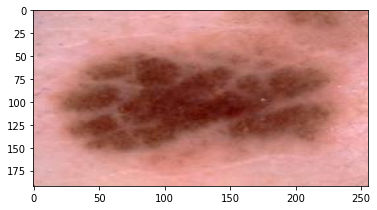

In [ ]:
# Displaying 1 image
data = io.BytesIO(open(orig_images[1],"rb").read())
image = Image.open(data)
plt.imshow(image,aspect=.7)

# ISIC mask(option1)

In [ ]:
def strip_filename(file):
    """
    This function makes an identifier that matches between both the base image and the masked image
    """
    if DATASET_USED == "ISIC_2017":
        # Cleaning files names here: https://github.com/manideep2510/melanoma_segmentation.git
        fn = file.name.replace("imgx","")
        fn = fn.replace("imgy","")
        path = file.parent.parts[-1].replace("x","").replace("y","")

    # Cleaning ISIC 2016 filenames
    if DATASET_USED == "ISIC_2016":
        fn = file.name.replace("_Segmentation","").replace(".jpg","").replace(".png","")
        path = file.parent.parts[-1].replace("_Data","").replace("_GroundTruth","")

    if DATASET_USED == "ISIC_2018":
        fn = file.name.replace("_segmentation","").replace(".jpg","").replace(".png","")
        path = file.parent.parts[-1].replace("-2_Training_Input","").replace("_Training_GroundTruth","")
    
    uuid = f"{path}/{fn}"
    return uuid
     

In [ ]:
def create_masked_image(image, mask):
    """
    This function takes in an image and mask in bytes. Since the mask is intended to be used to selected the
    skin lesion we need to invert the mask so we can remove the skin lesion. Once invert, the mask is applied the
    original image and then the new masked_image is return as a byte array.
    """
    
    orig_image = Image.open(io.BytesIO(image))
    
    imgpx = np.array(orig_image)

    mask_bytes = io.BytesIO(mask)
    mask = Image.open(mask_bytes)

    # Invert the mask
    mask = ImageOps.invert(mask) # need to invert the mask because we want to only remove the skin lesion
    #mask = mask.convert("1") 
    
    # apply mask to image
    #orig_image.paste(0,mask=mask)
    
    mask_pix = np.array(mask)    

    # Adding the mask to the image 
    #masked_flags = mask_pix != 0
    image_masked = np.where(mask_pix[...,None], imgpx,0)
    im_byte_array = Image.fromarray(image_masked)

    # Saving the masked image to a byte array
    img_byte_arr = io.BytesIO()
    orig_image = im_byte_array.convert('RGB')
    orig_image.save(img_byte_arr, format="JPEG")
    #img_byte_arr.seek(0)
    img_byte_arr = img_byte_arr.getvalue()

    return img_byte_arr
    #return img_byte_arr.read()

In [ ]:
def apply_mask_and_get_jpeg_bytes(image_path, mask_path):
  # Load the image and the mask
  image = Image.open(image_path)
  mask = Image.open(mask_path)

  # Invert the mask
  #mask = ImageOps.invert(mask)

  # Convert the mask to a boolean array
  mask = mask.convert("1")

  # Apply the mask to the image
  image.paste(0, mask=mask)

  # Create a BytesIO object to hold the JPEG data
  jpeg_bytes = io.BytesIO()

  # Save the image to the BytesIO object as a JPEG
  image.save(jpeg_bytes, format="JPEG")

  # Seek to the beginning of the BytesIO object
  jpeg_bytes.seek(0)

  # Return the JPEG data as a bytes object
  return jpeg_bytes.read()

# Fitzpatrick mask(option2)

 ## YCbCr Masking

In [ ]:
def pre_processing_rgb(RGB, verbose=False):
  # Subset dimensions
    R = RGB[:, :, 0]
    G = RGB[:, :, 1]
    B = RGB[:, :, 2]

    # Reduce to skin range
    R = np.where(R < 95, 0, R)
    G = np.where(G < 40, 0, G)
    B = np.where(B < 20, 0, B)

    R = np.where(R < G, 0, R)
    R = np.where(R < B, 0, R)
    R = np.where(abs(R - G) < 15, 0, R)

    R = np.where(G == 0, 0, R)
    R = np.where(B == 0, 0, R)

    B = np.where(R == 0, 0, B)
    B = np.where(G == 0, 0, B)

    G = np.where(R == 0, 0, G)
    G = np.where(B == 0, 0, G)

    if verbose: print("Stacking image")
    # Stack into RGB
    RGB = np.stack([R, G, B], axis = 2)
    return RGB


In [ ]:
def get_ycbcr_mask(RGB, verbose=False):   

    if verbose: print("Converting to YCBCR")
    # Convert to YCBCR color-space
    YCBCR = color.rgb2ycbcr(RGB)

    # Subset dimensions
    Y = YCBCR[:, :, 0]
    Cb = YCBCR[:, :, 1]
    Cr = YCBCR[:, :, 2]

    # Subset to skin range
    Y = np.where(Y < 80, 0, Y)
    Cb = np.where(Cb < 85, 0, Cb)
    Cr = np.where(Cr < 135, 0, Cr)

    Cr = np.where(Cr >= (1.5862*Cb) + 20, 0, Cr)
    Cr = np.where(Cr <= (0.3448*Cb) + 76.2069, 0, Cr)
    Cr = np.where(Cr <= (-4.5652*Cb) + 234.5652, 0, Cr)
    Cr = np.where(Cr >= (-1.15*Cb) + 301.75, 0, Cr)
    Cr = np.where(Cr >= (-2.2857*Cb) + 432.85, 0, Cr)

    Y = np.where(Cb == 0, 0, Y)
    Y = np.where(Cr == 0, 0, Y)

    Cb = np.where(Y == 0, 0, Cb)
    Cb = np.where(Cr == 0, 0, Cb)

    Cr = np.where(Y == 0, 0, Cr)
    Cr = np.where(Cb == 0, 0, Cr)

    if verbose: print("Stack mask to image")
    # Stack into skin region
    skinRegion = np.stack([Y, Cb, Cr], axis = 2)
    skinRegion = np.where(skinRegion != 0, 255, 0)
    skinRegion = skinRegion.astype(dtype = "uint8")
    return skinRegion


In [ ]:
def ycbcr(image, verbose=False):
    """
    Applies a YCbCr mask to an input image and 
    saves the resultant image

    Inputs:
        image - (str) RBG image file path

    Outputs:
        mask - (str) YCbCr image file path
    """
    if verbose: print("Reading image")
    # Read RGB image
    RGB = skimage.io.imread(image)

    RGB = pre_processing_rgb(RGB)    
  
    skinRegion = get_ycbcr_mask(RGB)

    if verbose: print("Applying mask")
    # Apply mask to original RGB image
    mask = np.array(RGB)
    mask = np.where(skinRegion != 0, mask, 0)
    
    new_filepath = 'ycbcr/{}'.format(image)
    if verbose: print(f"Saving to {new_filepath}")
    skimage.io.imsave(new_filepath,RGB)

    return new_filepath

## Testing mask on Fitzpatrick 17k image

In [ ]:
# clone fitzpatrick 17k
# read csv
# pick and doanload image
# run mask 
# display origional and mask imanges

In [ ]:
!git clone https://github.com/mattgroh/fitzpatrick17k.git

Cloning into 'fitzpatrick17k'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 79 (delta 26), reused 36 (delta 11), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
!ls fitzpatrick17k

annotation_evaluation  image_deduplication.ipynb       README.md
fitzpatrick17k.csv     ita_fitzpatrick_analysis.ipynb  train.py


In [ ]:
df = pd.read_csv("/content/fitzpatrick17k/fitzpatrick17k.csv")
url = df['url'][55]
fitz_test_filename = url.split("/")[-1]
fitz_test_filename

'psoriasis-pustular54.jpg'

In [ ]:
!wget $url

--2022-12-23 07:47:18--  https://www.dermaamin.com/site/images/clinical-pic/p/psoriasis-pustular/psoriasis-pustular54.jpg
Resolving www.dermaamin.com (www.dermaamin.com)... 50.87.176.30
Connecting to www.dermaamin.com (www.dermaamin.com)|50.87.176.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57288 (56K) [image/jpeg]
Saving to: ‘psoriasis-pustular54.jpg’

psoriasis-pustular5 100%[===================>]  55.95K  --.-KB/s    in 0.1s    

2022-12-23 07:47:18 (437 KB/s) - ‘psoriasis-pustular54.jpg’ saved [57288/57288]



In [ ]:
masked_image = ycbcr(fitz_test_filename)
masked_image

'ycbcr/psoriasis-pustular54.jpg'

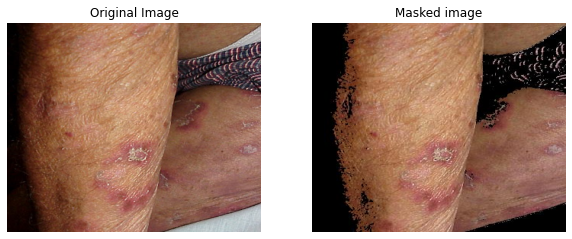

In [ ]:
f, axes = plt.subplots(1, 2)
f.set_size_inches(10,7)

ax = plt.subplot(1, 2, 1)
image = Image.open(io.BytesIO(open(fitz_test_filename,"rb").read()))

plt.imshow(image,aspect=.7)
plt.title(f"Original Image")
plt.axis("off")
plt.subplots_adjust(hspace = .3)


ax = plt.subplot(1, 2,2)
image = Image.open(io.BytesIO(open(masked_image,"rb").read()))
plt.imshow(image,aspect=.7)
plt.title(f"Masked image")
plt.axis("off")
plt.subplots_adjust(hspace = .3)


## Testing images and ITA


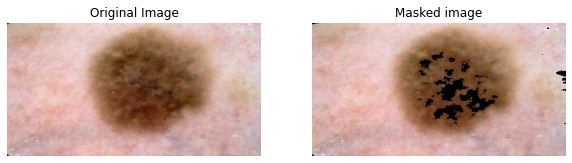

In [ ]:
image_index = 15

file_name = ycbcr(orig_images[image_index])


f, axes = plt.subplots(1, 2)
f.set_size_inches(10,7)

ax = plt.subplot(1, 2, 1)
image = Image.open(io.BytesIO(open(orig_images[image_index],"rb").read()))

plt.imshow(image,aspect=.7)
plt.title(f"Original Image")
plt.axis("off")
plt.subplots_adjust(hspace = .3)


ax = plt.subplot(1, 2,2)
image = Image.open(io.BytesIO(open(file_name,"rb").read()))
plt.imshow(image,aspect=.7)
plt.title(f"Masked image")
plt.axis("off")
plt.subplots_adjust(hspace = .3)

In [ ]:
image_ita = get_cropped_center_ita(image=Image.open(orig_images[image_index]))
image_ita

71.78477631806527

In [ ]:
get_kinyanjui_groh_type(image_ita)

'1'

# Utilities
Code to get random values of a specific Fitzpatrick skin type

In [ ]:
Fitzpatrick_Skin_Type = Enum("Fitzpatrick_Skin_Type", ["_1","_2","_3","_4","_5","_6"])

In [ ]:
from numpy.random.mtrand import randint


def random_ita_from_FST(skin_type: Fitzpatrick_Skin_Type):
  """
  This function will return a random number between the ITA ranges provided in
  https://openaccess.thecvf.com/content/CVPR2021W/ISIC/papers/Groh_Evaluating_Deep_Neural_Networks_Trained_on_Clinical_Images_in_Dermatology_CVPRW_2021_paper.pdf
    For skin types of 6 and 1 there are open ranges. The selected end ranges comes from computing the ITA
    on all the ISIC 2017 dataset images and takeing the largest ranges.
  :skin_type - input of the Fitzpatrick skin type
  """
  if skin_type == Fitzpatrick_Skin_Type._6:
    return randint(-10,10)
  elif skin_type == Fitzpatrick_Skin_Type._5:
    return randint(10,19)
  elif skin_type == Fitzpatrick_Skin_Type._4:
    return randint(19,28)
  elif skin_type == Fitzpatrick_Skin_Type._3:
    return randint(28,41)
  elif skin_type == Fitzpatrick_Skin_Type._2:
    return randint(41,55)
  elif skin_type == Fitzpatrick_Skin_Type._1:
    return randint(55,90)

In [ ]:
random_ita_from_FST(Fitzpatrick_Skin_Type["_4"])

26

In [ ]:
def random_FST(exclude=None):
    """
    This function will randomly pick a fitzpatrick skin type 
    :exclude - given a FST, this will not be chosen when randomly picking a FST
    """
    if exclude is None:
        return Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
    else:
        while True:
            fst = Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
            if fst != exclude:
                return fst
        

In [ ]:
random_FST(Fitzpatrick_Skin_Type._1)

<Fitzpatrick_Skin_Type._3: 3>

# Investigate the range of L and b for all images

This section evaluates the min, max, and mean of the luminosity and b values from a CIE-LAB color type.  

In [ ]:

l_min = []
l_max = []
l_average = []

b_min = []
b_max = []
b_average = []

df_investigation = pd.DataFrame(columns = ['l_min', 'l_max', 'l_average', 'b_min', 'b_max', 'b_average','a_min', 'a_average','a_max', 'ita_value', 'fitzpatrick_skin_type'])

# Loop over all images 
for file in orig_images:
    #print(file)
    
    image = Image.open(file)
    lab = np.array(skimage.color.rgb2lab(image))

    l = lab[:, :, 0]
    l = np.where(l != 0, l, np.nan)
    std = np.nanstd(l)
    mean = np.nanmean(l)
    l = np.where(l >= mean - std, l, np.nan)
    l = np.where(l <= mean + std, l, np.nan)

    b = lab[:, :, 2]    
    std = np.nanstd(b)
    mean = np.nanmean(b)
    b = np.where(b >= mean - std, b, np.nan)
    b = np.where(b <= mean + std, b, np.nan)


    a = lab[:, :, 1]    

    image_ita = get_cropped_center_ita(image)
    row = {
        'l_min' : np.nanmin(l),
        'l_max' : np.nanmax(l),
        'l_average' : np.nanmean(l),
        'b_min' : np.nanmin(b), 
        'b_max' : np.nanmax(b), 
        'b_average' : np.nanmean(b),
        'a_min' : np.nanmin(a), 
        'a_max' : np.nanmax(a), 
        'a_average' : np.nanmean(a), 
        'ita_value': image_ita, 
        'fitzpatrick_skin_type' : get_kinyanjui_groh_type(image_ita) 
    }
    df_investigation = df_investigation.append(row, ignore_index = True)



/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/derm_ita/ita_core_computations.py:75: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(l)
/usr/local/lib/python3.8/dist-packages/derm_ita/ita_core_computations.py:86: RuntimeWarning: Mean of empty slice
  ita = math.atan2(np.nanmean(l) - 50, np.nanmean(b)) * (180 / np.pi)


In [ ]:
df_investigation.groupby(['fitzpatrick_skin_type'])["b_average"].describe()

,count,mean,std,min,25%,50%,75%,max
fitzpatrick_skin_type,,,,,,,,
1,1634.0,6.765378,5.662960,-31.921971,3.770843,6.976905,9.955064,22.224826
2,414.0,13.981647,4.930556,0.350301,10.442165,14.595410,17.184976,30.727019
3,308.0,17.044594,6.667288,1.558907,11.576511,17.146311,21.729645,41.688839
4,145.0,18.602050,7.544644,2.217797,13.068131,17.562551,23.663258,40.831211
5,96.0,17.528373,8.507239,3.488756,10.535824,16.876584,23.355973,47.796930
6,153.0,13.369380,7.753400,-1.844633,8.093073,11.908144,18.422888,36.947793


In [ ]:
b_average_list = list(df_investigation.groupby(['fitzpatrick_skin_type'])["b_average"].mean())
print(df_investigation.groupby(['fitzpatrick_skin_type'])["b_average"].mean())
print(f"{'i':^5}{'j':^5}{'diff':^10}{'%':^10}{'%':^10}")
print("[",end="")
for i in range(len(b_average_list)):
    row = []
    for j in range(len(b_average_list)):
        #if i == j:
        #    continue
        diff =  b_average_list[j] - b_average_list[i]
        percent = diff / b_average_list[i]
        #print(f"{i:^5}{j:^5}{diff:^10.2f}{percent:^10.2f}{percent*100:^10.2f}")
        #print(f"l_modifier[{i}][{j}] = {percent:^10.2f}")
        percent = float(f"{percent:.2f}")
        row.append(percent)

        #print(f"{i}->{j} diff:{diff}{percent}")
    print(row,end="")
    print(",")
print("]",end="")

fitzpatrick_skin_type
1     6.765378
2    13.981647
3    17.044594
4    18.602050
5    17.528373
6    13.369380
Name: b_average, dtype: float64
  i    j     diff       %         %     
[[0.0, 1.07, 1.52, 1.75, 1.59, 0.98],
[-0.52, 0.0, 0.22, 0.33, 0.25, -0.04],
[-0.6, -0.18, 0.0, 0.09, 0.03, -0.22],
[-0.64, -0.25, -0.08, 0.0, -0.06, -0.28],
[-0.61, -0.2, -0.03, 0.06, 0.0, -0.24],
[-0.49, 0.05, 0.27, 0.39, 0.31, 0.0],
]

In [ ]:
b_modifier_list = [[0.0, 1.07, 1.52, 1.75, 1.59, 0.98],
[-0.52, 0.0, 0.22, 0.33, 0.25, -0.04],
[-0.6, -0.18, 0.0, 0.09, 0.03, -0.22],
[-0.64, -0.25, -0.08, 0.0, -0.06, -0.28],
[-0.61, -0.2, -0.03, 0.06, 0.0, -0.24],
[-0.49, 0.05, 0.27, 0.39, 0.31, 0.0],
]

In [ ]:
l_average_list = list(df_investigation.groupby(['fitzpatrick_skin_type'])["l_average"].mean())
print(f"{'i':^5}{'j':^5}{'diff':^10}{'%':^10}{'%':^10}")
print("[",end="")
for i in range(len(l_average_list)):
    row = []
    for j in range(len(l_average_list)):
        #if i == j:
        #    continue
        diff = l_average_list[j] - l_average_list[i]
        percent = diff / l_average_list[i]
        #print(f"{i:^5}{j:^5}{diff:^10.2f}{percent:^10.2f}{percent*100:^10.2f}")
        #print(f"l_modifier[{i}][{j}] = {percent:^10.2f}")
        percent = float(f"{percent:.2f}")
        row.append(percent)

        #print(f"{i}->{j} diff:{diff}{percent}")
    print(row,end="")
    print(",")
print("]",end="")
    

  i    j     diff       %         %     
[[0.0, -0.11, -0.16, -0.2, -0.25, -0.35],
[0.12, 0.0, -0.06, -0.11, -0.16, -0.28],
[0.19, 0.06, 0.0, -0.05, -0.1, -0.23],
[0.26, 0.13, 0.06, 0.0, -0.05, -0.18],
[0.33, 0.19, 0.11, 0.05, 0.0, -0.14],
[0.54, 0.38, 0.3, 0.23, 0.16, 0.0],
]

In [ ]:
l_modifier_table = [[0.0, -0.11, -0.16, -0.2, -0.25, -0.35],
[0.12, 0.0, -0.06, -0.11, -0.16, -0.28],
[0.19, 0.06, 0.0, -0.05, -0.1, -0.23],
[0.26, 0.13, 0.06, 0.0, -0.05, -0.18],
[0.33, 0.19, 0.11, 0.05, 0.0, -0.14],
[0.54, 0.38, 0.3, 0.23, 0.16, 0.0],
]

In [ ]:
a_average_list = list(df_investigation.groupby(['fitzpatrick_skin_type'])["a_average"].mean())
print(f"{'i':^5}{'j':^5}{'diff':^10}{'%':^10}{'%':^10}")
print("[",end="")
for i in range(len(a_average_list)):
    row = []
    for j in range(len(a_average_list)):
        #if i == j:
        #    continue
        diff = a_average_list[j] - a_average_list[i]
        percent = diff / a_average_list[i]
        #print(f"{i:^5}{j:^5}{diff:^10.2f}{percent:^10.2f}{percent*100:^10.2f}")
        #print(f"l_modifier[{i}][{j}] = {percent:^10.2f}")
        percent = float(f"{percent:.2f}")
        row.append(percent)

        #print(f"{i}->{j} diff:{diff}{percent}")
    print(row,end="")
    print(",")
print("]",end="")

  i    j     diff       %         %     
[[0.0, 0.4, 0.81, 0.9, 0.92, 0.67],
[-0.29, 0.0, 0.29, 0.35, 0.37, 0.19],
[-0.45, -0.22, 0.0, 0.05, 0.06, -0.08],
[-0.47, -0.26, -0.05, 0.0, 0.01, -0.12],
[-0.48, -0.27, -0.06, -0.01, 0.0, -0.13],
[-0.4, -0.16, 0.08, 0.14, 0.15, 0.0],
]

In [ ]:
a_modifier_table = [[0.0, 0.4, 0.81, 0.9, 0.92, 0.67],
[-0.29, 0.0, 0.29, 0.35, 0.37, 0.19],
[-0.45, -0.22, 0.0, 0.05, 0.06, -0.08],
[-0.47, -0.26, -0.05, 0.0, 0.01, -0.12],
[-0.48, -0.27, -0.06, -0.01, 0.0, -0.13],
[-0.4, -0.16, 0.08, 0.14, 0.15, 0.0],
]

In [ ]:
df_investigation.groupby(['fitzpatrick_skin_type'])["b_average"].mean()

fitzpatrick_skin_type
1     6.765378
2    13.981647
3    17.044594
4    18.602050
5    17.528373
6    13.369380
Name: b_average, dtype: float64

In [ ]:
df_investigation.groupby(['fitzpatrick_skin_type'])["a_average"].mean()

fitzpatrick_skin_type
1     8.678198
2    12.186117
3    15.710057
4    16.479254
5    16.644582
6    14.479874
Name: a_average, dtype: float64

1         AxesSubplot(0.1,0.15;0.114286x0.75)
2    AxesSubplot(0.237143,0.15;0.114286x0.75)
3    AxesSubplot(0.374286,0.15;0.114286x0.75)
4    AxesSubplot(0.511429,0.15;0.114286x0.75)
5    AxesSubplot(0.648571,0.15;0.114286x0.75)
6    AxesSubplot(0.785714,0.15;0.114286x0.75)
dtype: object

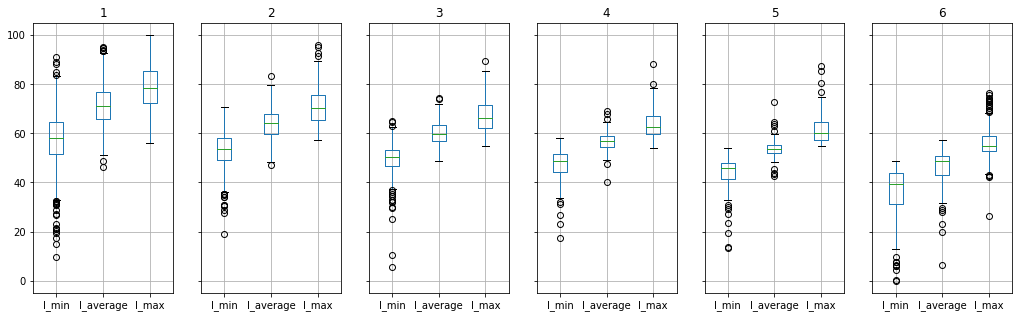

In [ ]:
df_investigation[["l_min", "l_average", "l_max",'fitzpatrick_skin_type']].groupby('fitzpatrick_skin_type').boxplot(figsize=(17,5), layout=(1,6))

1         AxesSubplot(0.1,0.15;0.114286x0.75)
2    AxesSubplot(0.237143,0.15;0.114286x0.75)
3    AxesSubplot(0.374286,0.15;0.114286x0.75)
4    AxesSubplot(0.511429,0.15;0.114286x0.75)
5    AxesSubplot(0.648571,0.15;0.114286x0.75)
6    AxesSubplot(0.785714,0.15;0.114286x0.75)
dtype: object

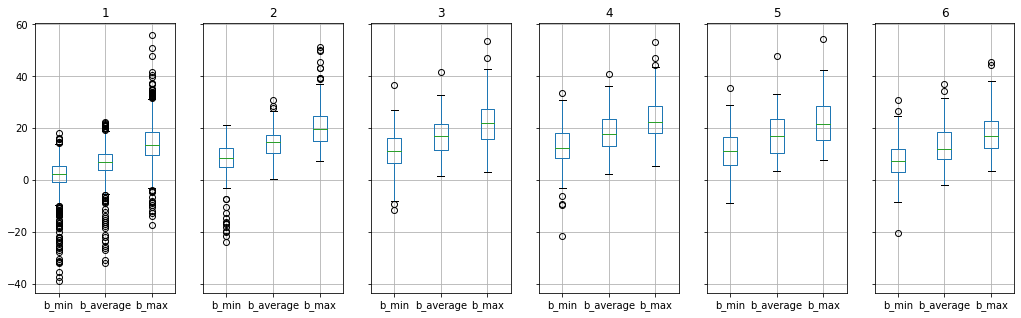

In [ ]:
df_investigation[["b_min", "b_average", "b_max",'fitzpatrick_skin_type']].groupby('fitzpatrick_skin_type').boxplot(figsize=(17,5), layout=(1,6))

1         AxesSubplot(0.1,0.15;0.114286x0.75)
2    AxesSubplot(0.237143,0.15;0.114286x0.75)
3    AxesSubplot(0.374286,0.15;0.114286x0.75)
4    AxesSubplot(0.511429,0.15;0.114286x0.75)
5    AxesSubplot(0.648571,0.15;0.114286x0.75)
6    AxesSubplot(0.785714,0.15;0.114286x0.75)
dtype: object

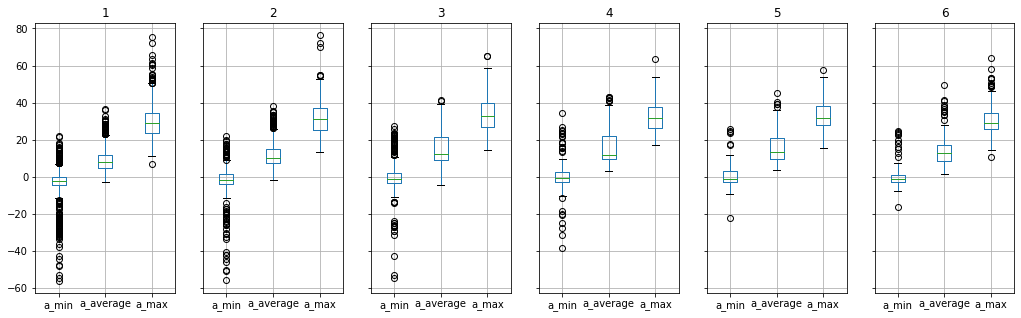

In [ ]:
df_investigation[["a_min", "a_average", "a_max",'fitzpatrick_skin_type']].groupby('fitzpatrick_skin_type').boxplot(figsize=(17,5), layout=(1,6))

## Adjust the color of the "skin"

To adjust the skin color to increase to decrease the ITA we can look into the formula of ITA which is ....

Plotting this graph we will see how both the x and y contribute to the ITA value

![Imgur](https://imgur.com/QKniAhx)



[plot @ wolframalpha](https://www.wolframalpha.com/input?i=plot+atan2%28x%2Cy%29+*+180%2Fpi)

# Transform image(Skin lesion mask option 1)

In [ ]:
def safe_convert(x, new_dtype):
    info = np.iinfo(new_dtype)
    return x.clip(info.min, info.max).astype(new_dtype)

In [368]:
def transform_image(image, mask,desired_fst=None, verbose=False):
    """
    1. Compute ITA of current image and retrieve Fitzpatrick skin type​
    2. Select random FST that’s different​
    3. Select random ITA number within range of selected FST​
    4. Compute difference  original ITA – new desired ITA​
    5. Adjusted b = old b value + (difference * .5)​
    6. Adjusted L = old L value + (difference * .12)
    :image - rgb image
    """
    
    image_ita = get_cropped_center_ita(image)
    if verbose: print(f"ITA {image_ita}")
    fst = Fitzpatrick_Skin_Type[f"_{get_kinyanjui_groh_type(image_ita)}"]
    if verbose: print(f"FST {fst}")
    if desired_fst == None:
        random_fst = random_FST(exclude=fst)
    else:
        random_fst = desired_fst
    if verbose: print(f"Random FST: {random_fst}")
    random_ita = random_ita_from_FST(random_fst)
    if verbose: print(f"Random ita: {random_ita}")
    difference = image_ita - random_ita
    if verbose: print(f"Difference ita: {difference}")

    # convert to boolean array
    mask = ImageOps.invert(mask)
    mask = mask.convert("1")

    image_array = np.array(image)
    # Convert the NumPy array to a cv2 image
    #cv2_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

    lab_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)

    # Adjust the B channel by multiplying by the factor    
    if random_fst.value < fst.value:
        b_modifier = .31
        l_modifier = -.09
        a_modifier = -.06    
    else:
        if diff >25:
            b_modifier = .76
            l_modifier = -.85
        else:
            b_modifier = .56
            l_modifier = -.65
        a_modifier = .1    
    if verbose:print(f"b_modifier: {b_modifier} random_fst.value {random_fst} {random_fst.value} fst.value {fst} {fst.value}")
    #print(lab_image.dtype)
    lab_image = safe_convert(lab_image,np.int64)            
    #print(lab_image.dtype)
    lab_image[:,:,2][mask] += int(difference * b_modifier)
    lab_image[:,:,1][mask] += int(difference * a_modifier)        
    lab_image[:,:,0][mask] += int(difference * l_modifier)
    lab_image = safe_convert(lab_image,np.uint8)


    # Convert the image back to the original color space
    adjusted_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    if verbose:
        # Save the LAB image to a file
        cv2.imwrite("test.jpg", adjusted_image)
            
        image = Image.open(io.BytesIO(open("test.jpg","rb").read()))
            
        image_ita = get_cropped_center_ita(image)    
        print(f"Updated ITA {image_ita}")
    print(adjusted_image.dtype)
    # To get a PIL image type you need to do this:
    # Image.fromarray(util.img_as_ubyte(rgb))
    # source: https://stackoverflow.com/a/55893334
    return adjusted_image

In [ ]:
%%time
dict_data = {}
data_list = []
for file in orig_images:    
    dict_data[strip_filename(file)] = file

for file in masks_images:
    
    # Adding the previous image to the new item so it will include both mask and image    
    image = open(dict_data[strip_filename(file)],"rb").read()    
    mask = open(file,"rb").read()

    # now to cut the mask out of the image
    masked_image = apply_mask_and_get_jpeg_bytes(dict_data[strip_filename(file)], file)
    data_list.append([strip_filename(file), image, mask, masked_image, file ])

# now to create the dataframe
df = pd.DataFrame(data=data_list, columns=["ID","image", "mask", "masked_image","file"])

CPU times: user 4.01 s, sys: 225 ms, total: 4.24 s
Wall time: 4.28 s


In [ ]:
image_index = random.randint(0,1000)

In [369]:
image = Image.open(io.BytesIO(df.iloc[image_index].image))
masked_image = Image.open(df.iloc[image_index].file)
image_rgb = transform_image(image, masked_image,Fitzpatrick_Skin_Type._1, verbose=True)

ITA 8.20027887020597
FST Fitzpatrick_Skin_Type._6
Random FST: Fitzpatrick_Skin_Type._1
Random ita: 84
Difference ita: -75.79972112979402
b_modifier: 0.31 random_fst.value Fitzpatrick_Skin_Type._1 1 fst.value Fitzpatrick_Skin_Type._6 6
Updated ITA 131.23964483160762
uint8


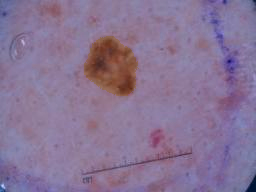

In [371]:
Image.fromarray(util.img_as_ubyte(image_rgb))

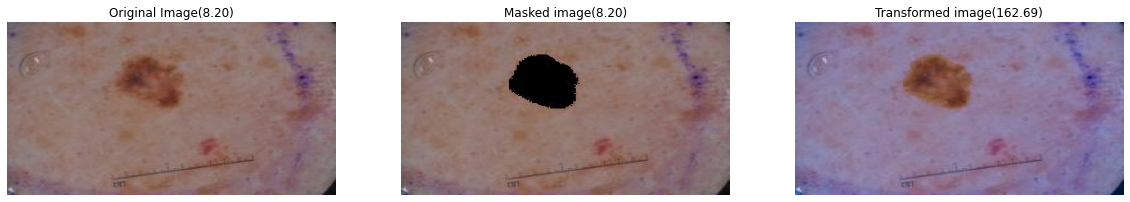

In [ ]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(20,7)

ax = plt.subplot(1, 3, 1)
image = Image.open(io.BytesIO(df.iloc[image_index].image))
image_ita = get_cropped_center_ita(image=image)
plt.imshow(image,aspect=.7)
plt.title(f"Original Image({image_ita:.2f})")
plt.axis("off")
plt.subplots_adjust(hspace = .3)

ax = plt.subplot(1, 3,2)

image = Image.open(io.BytesIO(df.iloc[image_index].masked_image))
plt.imshow(image,aspect=.7)
image_ita = get_cropped_center_ita(image=image)
plt.title(f"Masked image({image_ita:.2f})")
plt.axis("off")
plt.subplots_adjust(hspace = .3)


ax = plt.subplot(1, 3,3)
image = Image.open(io.BytesIO(open("test.jpg","rb").read()))
plt.imshow(image,aspect=.7)
image_ita = get_cropped_center_ita(image=Image.open("test.jpg"))
plt.title(f"Transformed image({image_ita:.2f})")
plt.axis("off")
plt.subplots_adjust(hspace = .3)

# Transform image (YCbCr option 2)

In [ ]:
def transform_image(image, verbose=False):
    """
    1. Compute ITA of current image and retrieve Fitzpatrick skin type​
    2. Select random FST that’s different​
    3. Select random ITA number within range of selected FST​
    4. Compute difference  original ITA – new desired ITA​
    5. Adjusted b = old b value + (difference * .5)​
    6. Adjusted L = old L value + (difference * .12)
    :image - rgb image
    """
    
    image_ita = get_cropped_center_ita(image)
    if verbose: print(f"ITA {image_ita}")
    fst = Fitzpatrick_Skin_Type[f"_{get_kinyanjui_groh_type(image_ita)}"]
    if verbose: print(f"FST {fst}")
    random_fst = random_FST(exclude=fst)
    if verbose: print(f"Random FST: {random_fst}")
    random_ita = random_ita_from_FST(random_fst)
    if verbose: print(f"Random ita: {random_ita}")
    difference = image_ita - random_ita
    if verbose: print(f"Difference ita: {difference}")

    ### Doing mask processing
    RGB = pre_processing_rgb(np.array(image))      
    skinRegion = get_ycbcr_mask(RGB)
    
    # Apply mask to original RGB image
    mask = np.array(RGB)
    mask = np.where(skinRegion != 0, mask, 0)

    lab_mask = np.array(skimage.color.rgb2lab(mask))
    lab_mask_mask = lab_mask[:,:,2] != 0
     

    # Get original image
    lab = np.array(skimage.color.rgb2lab(image))

    
    # Only update the b on the mask
    b = lab[:, :, 2]
    b[lab_mask_mask] += difference *.5    
    lab[:, :, 2] = b

    # adjust l
    l = lab[:, :, 0]    
    l[lab_mask_mask] -= difference * .12    
    lab[:, :, 0] = l


    rgb = skimage.color.lab2rgb(lab)
    skimage.io.imsave("test.jpg",rgb)
    image = Image.open(io.BytesIO(open("test.jpg","rb").read()))
        
    image_ita = get_cropped_center_ita(image)    
    if verbose: print(f"Updated ITA {image_ita}")
    
    # To get a PIL image type you need to do this:
    # Image.fromarray(util.img_as_ubyte(rgb))
    # source: https://stackoverflow.com/a/55893334
    return rgb


 ## Testing skin transformer

In [ ]:
image_index = random.randint(0,1000)

In [ ]:
image_rgb = transform_image(Image.open(io.BytesIO(open(orig_images[image_index],"rb").read())), verbose=True)

ITA 41.775244873132664
FST Fitzpatrick_Skin_Type._2
Random FST: Fitzpatrick_Skin_Type._6
Random ita: 9
Difference ita: 32.775244873132664
Updated ITA 17.21832940194831


### Origional, Transformed, and Masked images

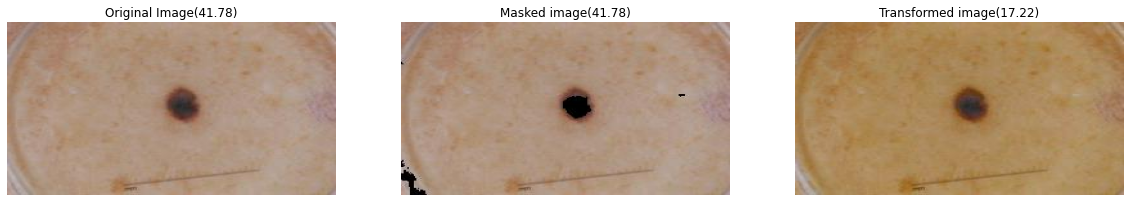

In [ ]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(20,7)

ax = plt.subplot(1, 3, 1)
image = Image.open(io.BytesIO(open(orig_images[image_index],"rb").read()))
image_ita = get_cropped_center_ita(image=Image.open(orig_images[image_index]))
plt.imshow(image,aspect=.7)
plt.title(f"Original Image({image_ita:.2f})")
plt.axis("off")
plt.subplots_adjust(hspace = .3)

ax = plt.subplot(1, 3,2)
file_name = ycbcr(orig_images[image_index])
image = Image.open(io.BytesIO(open(file_name,"rb").read()))
plt.imshow(image,aspect=.7)
image_ita = get_cropped_center_ita(image=Image.open(file_name))
plt.title(f"Masked image({image_ita:.2f})")
plt.axis("off")
plt.subplots_adjust(hspace = .3)


ax = plt.subplot(1, 3,3)
image = Image.open(io.BytesIO(open("test.jpg","rb").read()))
plt.imshow(image,aspect=.7)
image_ita = get_cropped_center_ita(image=Image.open("test.jpg"))
plt.title(f"Transformed image({image_ita:.2f})")
plt.axis("off")
plt.subplots_adjust(hspace = .3)

